# Imports

In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.decomposition import PCA

from robpy.utils.outlyingness import stahel_donoho
from robpy.pca import get_od_cutoff, ROBPCAEstimator
from robpy.covariance import FastMCDEstimator
  
%reload_ext autoreload
%autoreload 2

# Data simulation

In [4]:
n_clean = 1000
np.random.seed(42)
clean_data = np.random.multivariate_normal([0, 3, -5], cov=[[10, 3, 0.1], [3, 6, -2], [0.1, -2, 1]], size=n_clean)
outliers = np.random.multivariate_normal([2, 8, 0], cov=np.diag(np.ones(3)), size = 100)
X = np.concatenate([clean_data, outliers])

Text(0.5, 0, 'z')

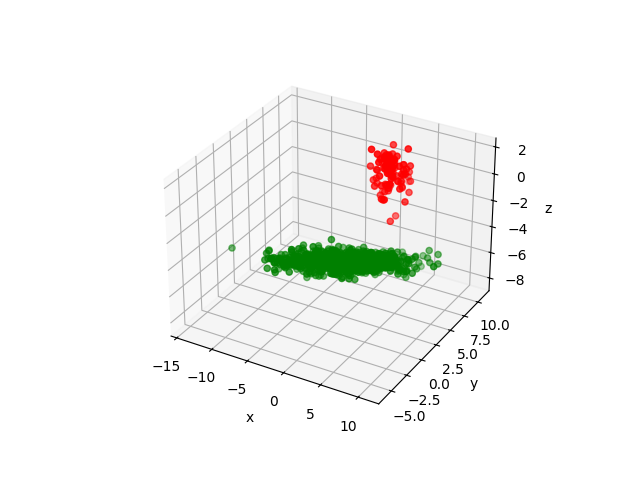

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(clean_data[:, 0], clean_data[:, 1], clean_data[:, 2], c='g', marker='o')
ax.scatter(outliers[:, 0], outliers[:, 1], outliers[:, 2], c='r', marker='o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


# ROBPCA

## Step 1: Orthogonalize

In [6]:
X = PCA().fit_transform(X)

## Step 2: H subset

(1100, 250)


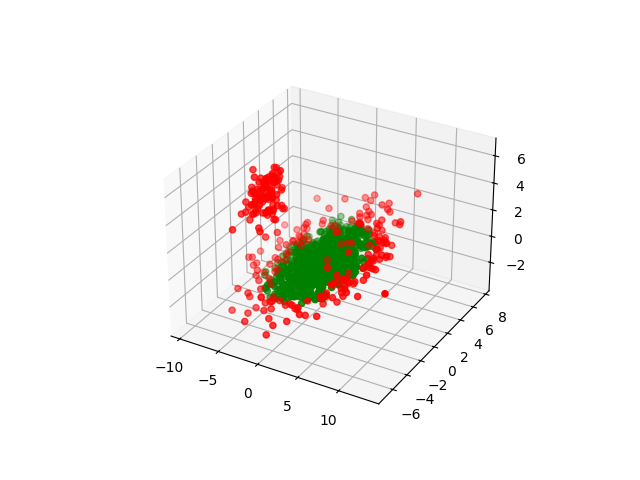

In [7]:
alpha = 0.75
outlyingness = stahel_donoho(X)
h_index = np.argsort(outlyingness)[: int(alpha * X.shape[0])]
h_cov = np.cov(X[h_index], rowvar=False)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[h_index, 0], X[h_index, 1], X[h_index, 2], c='g', marker='o')
X_out = np.delete(X, h_index, axis=0)
ax.scatter(X_out[:, 0], X_out[:, 1], X_out[:, 2], c='r', marker='o')

## Step 3: projection on k dimensional subspace

In [8]:
eigvals_h, eigvecs_h = np.linalg.eigh(h_cov)
sorted_eig_h_idx = np.argsort(eigvals_h)[::-1]
var_explained = eigvals_h[sorted_eig_h_idx].cumsum() / eigvals_h.sum()

print(var_explained)


[0.65026695 0.98716467 1.        ]


In [9]:
h_components = eigvecs_h[:, sorted_eig_h_idx[: 2]]  # (p, k)
X_proj = (X - X.mean(axis=0)) @ h_components @ h_components.T

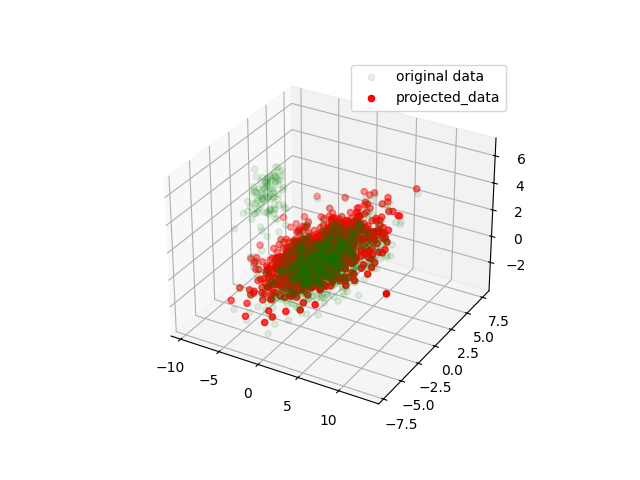

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='g', marker='o', label='original data', alpha=0.1)
ax.scatter(X_proj[:, 0], X_proj[:, 1], X_proj[:, 2], c='r', marker='o', label='projected_data')
ax.legend()

## Step 4: Orthogonal distance subset

In [24]:
orth_dist = np.linalg.norm((X - X.mean(axis=0)) - X_proj, axis=1)
v_index = np.argwhere(orth_dist < get_od_cutoff(orth_dist)).flatten()
eigvals_v, eigvecs_v = np.linalg.eigh(np.cov(X[v_index], rowvar=False))
sorted_eig_v_idx = np.argsort(eigvals_v)[::-1]

pc = eigvecs_v[:, sorted_eig_v_idx]  # (p, k)

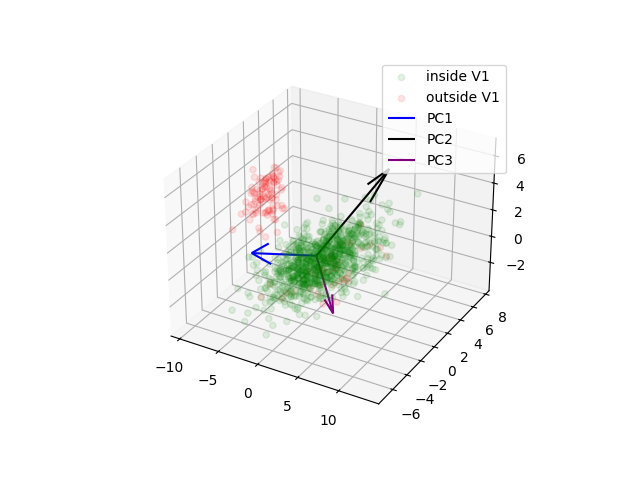

In [28]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[v_index, 0], X[v_index, 1], X[v_index, 2], c='g', marker='o', label='inside V1', alpha=0.1)
X_out = np.delete(X, v_index, axis=0)
ax.scatter(X_out[:, 0], X_out[:, 1], X_out[:, 2], c='r', marker='o', label='outside V1', alpha=0.1)

ax.quiver(0, 0, 0, *pc[:, 0]*10, label='PC1', color='blue')
ax.quiver(0, 0, 0, *pc[:, 1]*10, label='PC2', color='black')
ax.quiver(0, 0, 0, *pc[:, 2]*5, label='PC3', color='purple')
ax.legend()

## Step 5: MCD

In [ ]:
mcd = FastMCDEstimator().fit(((X - X.mean(axis=0)) @ pc[:, :2] @ pc[:, :2].T))
eigvals_mcd, eigvecs_mcd = np.linalg.eigh(mcd.covariance)
sorted_eig_mcd_idx = np.argsort(eigvals_v)[::-1]

## E2E

In [33]:
pca = ROBPCAEstimator().fit(X)

(1100, 250)


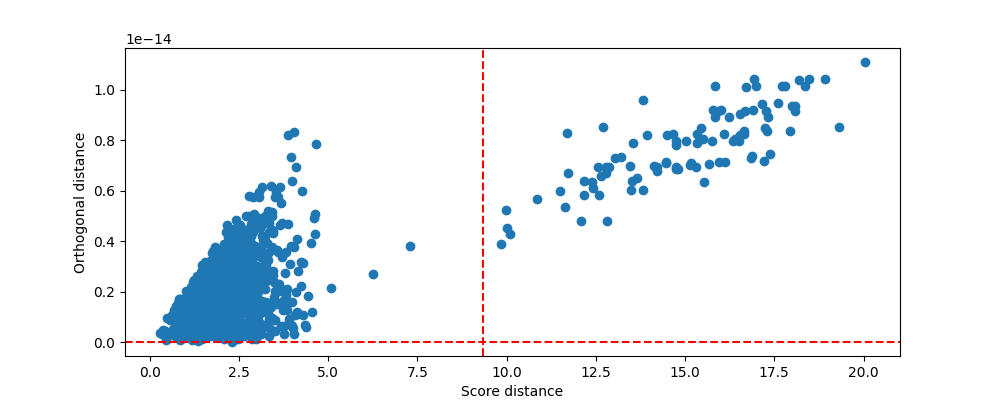

In [46]:
sd, od, sdc, odc = pca.plot_outlier_map(X, return_distances=True)

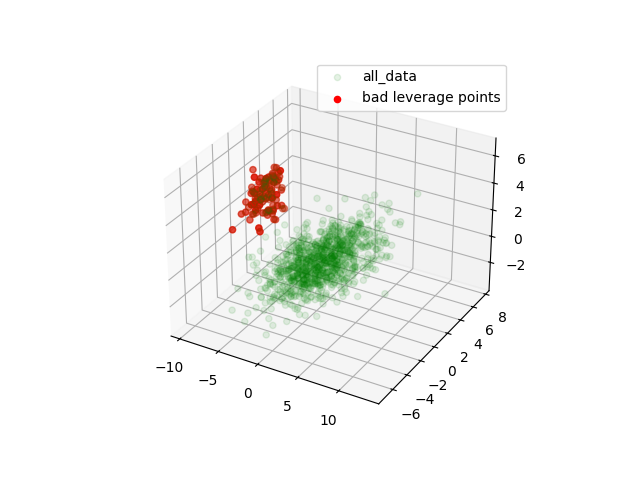

In [47]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='g', marker='o', label='all_data', alpha=0.1)
ax.scatter(X[(sd>sdc) & (od>odc), 0], X[(sd>sdc) & (od>odc), 1], X[(sd>sdc) & (od>odc), 2], c='r', marker='o', label='bad leverage points')
ax.legend()